<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
'SiPM DST' Study</p><br>

# Ilustrates the data structure to prepare a DST from FLEX data

In [83]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [84]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

# Specific IC stuff
import invisible_cities.core.system_of_units  as units

from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.core.core_functions import in_range


In [85]:
from nextflex.krypton_dst import get_evt_true_positions_and_energy
from nextflex.krypton_dst import NN

In [86]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [6]:
VERBOSITY = False

### Input data

In [88]:
iPATH = "/Users/jj/Development/flexData/FLEX100_M6_O6"

In [89]:
ifnames = glob.glob(f"{iPATH}/*.h5")

if VERBOSITY:
    print(f"{len(ifnames)} input file names ...\n")
    for ifname in ifnames:
        print(ifname)
        #print(get_event_numbers_in_file(ifname))
else:
    print(f"{len(ifnames)} input file names ...\n")

100 input file names ...



In [90]:
# Verbosing main config parameters
mcConfig = load_mcconfiguration(ifnames[0])
mcConfig.set_index("param_key", inplace = True)
main_params = ["/Geometry/NextFlex/e_lifetime", "/Geometry/NextFlex/el_gap_length",
               "/Geometry/NextFlex/el_field_int", "/Geometry/NextFlex/tp_sipm_anode_dist",
               "/Geometry/NextFlex/tp_teflon_thickness", "/Geometry/NextFlex/tp_teflon_hole_diam",
               "/Geometry/NextFlex/tp_sipm_sizeX", "/Geometry/NextFlex/tp_sipm_pitchX",
               "num_events", "TP_SiPM_binning", "F_SENSOR_L_binning", "F_SENSOR_R_binning"]

print(mcConfig.loc[mcConfig.index.intersection(main_params)])


                                                param_value
param_key                                                  
num_events                                              100
TP_SiPM_binning                                1.000000 mus
/Geometry/NextFlex/e_lifetime                      1000. ms
/Geometry/NextFlex/el_gap_length                    10.  mm
/Geometry/NextFlex/el_field_int             16. kilovolt/cm
/Geometry/NextFlex/tp_teflon_thickness              6.   mm
/Geometry/NextFlex/tp_teflon_hole_diam              6.   mm
/Geometry/NextFlex/tp_sipm_sizeX                   1.3   mm
/Geometry/NextFlex/tp_sipm_pitchX                  15.55 mm


In [91]:
par = mcConfig.loc["/Geometry/NextFlex/tp_sipm_pitchX"]
par

param_value           15.55 mm
Name: /Geometry/NextFlex/tp_sipm_pitchX, dtype: object

#### Extract pitch from params

In [92]:
pitch = float(par.param_value.split(' ')[-2])
pitch

15.55

#### Index for PMTs and SiPMs

In [66]:
pmt_ids  = 100
sipm_ids = (pmt_ids, 100000)

### read SiPM map

In [14]:
sipm_map = pd.read_csv('sipm_map.csv')

In [15]:
sipm_map

,Unnamed: 0,sensor_id,sensor_name,x,y,xl,xr,yu,yd,id_xl,id_xr,id_yu,id_yd
0,0,1040,TP_SiPM,15.55,-450.95,1.907349e-07,31.100000,-435.400012,-466.500012,1039,1041,1066,1019
1,1,4059,TP_SiPM,93.30,450.95,7.775000e+01,108.850003,466.500012,435.400012,4058,4060,4080,4033
2,2,3753,TP_SiPM,-62.20,326.55,-7.775000e+01,-46.650001,342.099988,310.999988,3752,3754,3799,3705
3,3,3842,TP_SiPM,-77.75,357.65,-9.330000e+01,-62.200000,373.199994,342.099994,3841,3843,3884,3798
4,4,3797,TP_SiPM,-93.30,342.10,-1.088500e+02,-77.750003,357.650006,326.550006,3796,3798,3841,3751
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3088,3088,1717,TP_SiPM,311.00,-217.70,2.954500e+02,326.550000,-202.149997,-233.249997,1716,1718,1774,1661
3089,3089,2317,TP_SiPM,357.65,-62.20,3.421000e+02,373.199994,-46.650001,-77.750001,2316,2318,2380,2255
3090,3090,1676,TP_SiPM,-326.55,-217.70,-3.421000e+02,-310.999988,-202.149997,-233.249997,1675,1677,1733,1620
3091,3091,3517,TP_SiPM,186.60,248.80,1.710500e+02,202.150006,264.350003,233.250003,3516,3518,3570,3463


## Sensors

In [16]:
get_sensor_binning(ifnames[0])

,bin_width
sns_name,
PmtR11410,25.0
TP_SiPM,1000.0


In [17]:
sns_types = get_sensor_types(ifnames[0])
sns_types.head()

,sensor_id,sensor_name
0,9,PmtR11410
1,20,PmtR11410
2,32,PmtR11410
3,3,PmtR11410
4,35,PmtR11410


In [18]:
sns_positions = load_mcsensor_positions(ifnames[0])
sns_positions.head()

,sensor_id,sensor_name,x,y,z
0,9,PmtR11410,-250.000000,3.061617e-14,1468.699951
1,20,PmtR11410,-187.500000,3.247595e+02,1468.699951
2,32,PmtR11410,-312.581116,1.082064e+02,1468.699951
3,3,PmtR11410,-125.000000,1.530808e-14,1468.699951
4,35,PmtR11410,312.581116,-1.082064e+02,1468.699951


## True position from MC particles

#### MC Particles

In [19]:
mcParts = load_mcparticles_df(ifnames[0])
print(mcParts.columns)
mcParts

Index(['particle_name', 'primary', 'mother_id', 'initial_x', 'initial_y',
       'initial_z', 'initial_t', 'final_x', 'final_y', 'final_z', 'final_t',
       'initial_volume', 'final_volume', 'initial_momentum_x',
       'initial_momentum_y', 'initial_momentum_z', 'final_momentum_x',
       'final_momentum_y', 'final_momentum_z', 'kin_energy', 'length',
       'creator_proc', 'final_proc'],
      dtype='object')


particle_name  primary  mother_id   initial_x  \
event_id particle_id                                                 
102300   2                      e-     True          0  -62.492722   
         1                      e-     True          0  -62.492722   
102301   2                      e-     True          0 -350.010284   
         1                      e-     True          0 -350.010284   
102302   2                      e-     True          0   -5.467896   
...                            ...      ...        ...         ...   
102397   1                      e-     True          0  360.786621   
102398   2                      e-     True          0 -350.918549   
         1                      e-     True          0 -350.918549   
102399   2                      e-     True          0 -293.788391   
         1                      e-     True          0 -293.788391   

                       initial_y    initial_z  initial_t     final_x  \
event_id particle_id                                                   
102300   2           -368.931854  1170.443604        0.0  -62.482391   
         1           -368.931854  1170.443604        0.0  -62.509209   
102301   2           -131.459610  1079.000977        0.0 -350.021210   
         1           -131.459610  1079.000977        0.0 -349.778503   
102302   2            -10.789518   622.053040        0.0   -5.477514   
...                          ...          ...        ...         ...   
102397   1           -186.341110   187.116257        0.0  360.839233   
102398   2            333.981506   148.126694        0.0 -350.928314   
         1            333.981506   148.126694        0.0 -350.918457   
102399   2            262.808014   819.945129        0.0 -293.795776   
         1            262.808014   819.945129        0.0 -293.656128   

                         final_y      final_z  ...  initial_momentum_x  \
event_id particle_id                           ...                       
102300   2           -368.939941  1170.429077  ...            0.095422   
         1           -368.853851  1170.631470  ...           -0.076847   
102301   2           -131.453522  1078.994873  ...           -0.075752   
         1           -131.379425  1078.938599  ...            0.165311   
102302   2            -10.792948   622.058838  ...           -0.071990   
...                          ...          ...  ...                 ...   
102397   1           -186.417511   187.155334  ...           -0.102543   
102398   2            333.992554   148.129196  ...            0.033385   
         1            334.086761   148.163925  ...            0.022561   
102399   2            262.836090   819.925476  ...            0.010585   
         1            262.755524   819.943787  ...           -0.000645   

                     initial_momentum_y initial_momentum_z  final_momentum_x  \
event_id particle_id                                                           
102300   2                     0.008014          -0.022835               0.0   
         1                     0.098361           0.135305               0.0   
102301   2                    -0.026113           0.057190              -0.0   
         1                    -0.075761           0.028644              -0.0   
102302   2                     0.066618           0.008394              -0.0   
...                                 ...                ...               ...   
102397   1                    -0.144178          -0.050848              -0.0   
102398   2                    -0.026013          -0.088880              -0.0   
         1                     0.176768          -0.046173               0.0   
102399   2                     0.053660          -0.081851               0.0   
         1                    -0.172316           0.064767              -0.0   

                      final_momentum_y  final_momentum_z  kin_energy  \
event_id particle_id                                                   
102300   2               

In [20]:
mcParts.index

MultiIndex([(102300, 2),
            (102300, 1),
            (102301, 2),
            (102301, 1),
            (102302, 2),
            (102302, 1),
            (102303, 2),
            (102303, 1),
            (102304, 3),
            (102304, 2),
            ...
            (102395, 2),
            (102395, 1),
            (102396, 2),
            (102396, 1),
            (102397, 2),
            (102397, 1),
            (102398, 2),
            (102398, 1),
            (102399, 2),
            (102399, 1)],
           names=['event_id', 'particle_id'], length=407)

In [21]:
evt_truePos = mcParts.loc[pd.IndexSlice[:, 1], ['initial_x', 'initial_y', 'initial_z']]

In [22]:
evt_truePos

,,initial_x,initial_y,initial_z
event_id,particle_id,,,
102300,1,-62.492722,-368.931854,1170.443604
102301,1,-350.010284,-131.459610,1079.000977
102302,1,-5.467896,-10.789518,622.053040
102303,1,188.554916,98.998077,810.298279
102304,1,-86.077446,234.479935,1120.656860
...,...,...,...,...
102395,1,265.239990,112.474052,707.629028
102396,1,409.284576,33.916729,1009.684021
102397,1,360.786621,-186.341110,187.116257


In [23]:
mcParts.index[0][0]

102300

In [24]:
evt0 = mcParts[mcParts.primary].loc[mcParts.index[0][0]]

In [25]:
evt0

,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
particle_id,,,,,,,,,,,,,,,,,,,,,
2,e-,True,0,-62.492722,-368.931854,1170.443604,0.0,-62.482391,-368.939941,1170.429077,...,0.095422,0.008014,-0.022835,0.0,0.0,0.0,0.009396,0.067283,none,Scintillation
1,e-,True,0,-62.492722,-368.931854,1170.443604,0.0,-62.509209,-368.853851,1170.631470,...,-0.076847,0.098361,0.135305,0.0,0.0,-0.0,0.032147,0.452093,none,Scintillation


## Krypton energy in keV

In [26]:
Ekr = np.sum(evt0.kin_energy)*1e+3
print(f'Krypton energy in keV = {Ekr}')

Krypton energy in keV = 41.543297469615936


In [27]:
grouped_multiple = mcParts.groupby(['event_id']).agg({'kin_energy': ['sum']})
grouped_multiple.columns = ['KE']
KEdf = grouped_multiple.reset_index()
KEdf

,event_id,KE
0,102300,0.041543
1,102301,0.041543
2,102302,0.041543
3,102303,0.041543
4,102304,0.053747
...,...,...
95,102395,0.041543
96,102396,0.041543
97,102397,0.041543
98,102398,0.041543


## S1 time

In [28]:
s1_time = 1 * units.mus

#### MC Hits

In [29]:
mcHits = load_mchits_df(ifnames[0])
print(mcHits.columns)
mcHits.head()

Index(['x', 'y', 'z', 'time', 'energy', 'label'], dtype='object')


x           y            z      time  \
event_id particle_id hit_id                                                 
102300   2           0      -62.489300 -368.933319  1170.441528  0.000075   
                     1      -62.486927 -368.935364  1170.438965  0.000149   
                     2      -62.484169 -368.937317  1170.437622  0.000215   
                     3      -62.482372 -368.938873  1170.434814  0.000283   
                     4      -62.481560 -368.939941  1170.428345  0.000406   

                               energy   label  
event_id particle_id hit_id                    
102300   2           0       0.000494  ACTIVE  
                     1       0.000156  ACTIVE  
                     2       0.000270  ACTIVE  
                     3       0.000023  ACTIVE  
                     4       0.002526  ACTIVE

In [30]:
true_positions = get_evt_true_positions_and_energy(mcParts)

In [31]:
true_positions

,true_x,true_y,true_z,KE
event_id,,,,
102300,-62.492722,-368.931854,1170.443604,41.543297
102301,-350.010284,-131.459610,1079.000977,41.543297
102302,-5.467896,-10.789518,622.053040,41.543297
102303,188.554916,98.998077,810.298279,41.543297
102304,-86.077446,234.479935,1120.656860,53.747372
...,...,...,...,...
102395,265.239990,112.474052,707.629028,41.543297
102396,409.284576,33.916729,1009.684021,41.543297
102397,360.786621,-186.341110,187.116257,41.543297


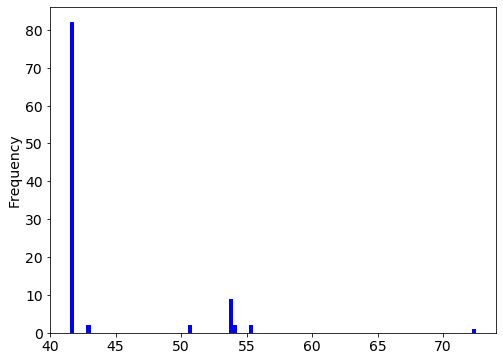

In [32]:
true_positions['KE'].plot(kind='hist', bins=100, color='blue')

In [33]:
def histo_var(df, var, varmin, varmax, bins=10, alpha=0.6, color='g'):
    df1 = df[df[var] < varmax]
    df2 = df1[df1[var] > varmin]
    plt.hist(df2[var].values, bins=bins, alpha=alpha, color=color)
    
    

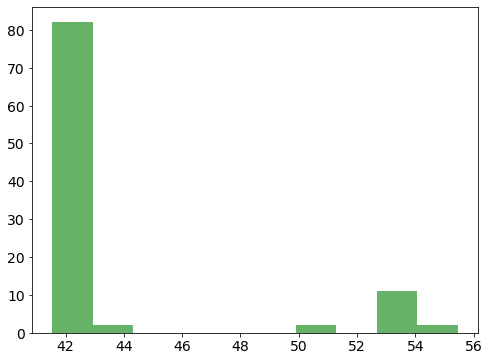

In [34]:
histo_var(true_positions, var='KE', varmin=40, varmax=60, bins=10, alpha=0.6, color='g')

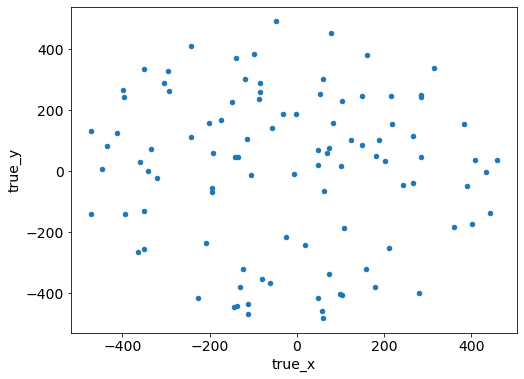

In [35]:
true_positions.plot(kind='scatter', x='true_x', y='true_y')

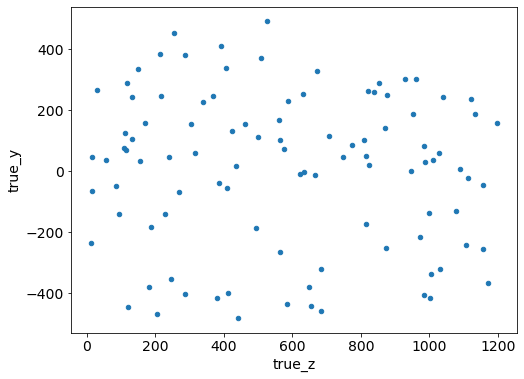

In [36]:
true_positions.plot(kind='scatter', x='true_z', y='true_y')

## SENSORS RESPONSE

In [37]:
sns_response = load_mcsensor_response_df(ifnames[0])
sns_response

charge       time
event_id sensor_id                   
102300   9               1  1165400.0
         9               1  1167125.0
         9               1  1167450.0
         9               1  1167575.0
         9               1  1167675.0
...                    ...        ...
102371   2057            1   219000.0
102397   2057            1   187000.0
102381   1979            1   680000.0
102389   1979            1    55000.0
102395   1979            1   705000.0

[672759 rows x 2 columns]

In [41]:
sns_response.index.get_level_values("sensor_id")

UInt64Index([   9,    9,    9,    9,    9,    9,    9,    9,    9,    9,
             ...
             2120, 2120, 2120, 2120, 2057, 2057, 2057, 1979, 1979, 1979],
            dtype='uint64', name='sensor_id', length=672759)

In [64]:
sipm_ids[0]

100

In [65]:
sipm_ids[1]

101

In [59]:
sipm_1 = sns_response.index.get_level_values("sensor_id") >100
sipm_1

array([False, False, False, ...,  True,  True,  True])

In [60]:
sipm_2 = sns_response.index.get_level_values("sensor_id") <=100000
sipm_2

array([ True,  True,  True, ...,  True,  True,  True])

In [61]:
sipm_1 & sipm_2

array([False, False, False, ...,  True,  True,  True])

In [67]:
sipm_response = sns_response[in_range(sns_response.index.get_level_values("sensor_id"),
                                     *sipm_ids)]

In [69]:
pmt_response = sns_response[sns_response.index.get_level_values("sensor_id") <=pmt_ids]

In [70]:
pmt_response

charge       time
event_id sensor_id                   
102300   9               1  1165400.0
         9               1  1167125.0
         9               1  1167450.0
         9               1  1167575.0
         9               1  1167675.0
...                    ...        ...
102399   39              1   824775.0
         39              1   824975.0
         39              1   825600.0
         39              1   827300.0
         39              1   827900.0

[623233 rows x 2 columns]

In [68]:
sipm_response

charge       time
event_id sensor_id                   
102300   1190            1  1174000.0
102306   1190            1  1092000.0
         1190            1  1095000.0
102320   1190            1   575000.0
102327   1190            1   381000.0
...                    ...        ...
102371   2057            1   219000.0
102397   2057            1   187000.0
102381   1979            1   680000.0
102389   1979            1    55000.0
102395   1979            1   705000.0

[49526 rows x 2 columns]

In [71]:
grouped_multiple = sipm_response.groupby(['event_id', 'sensor_id']).agg({'charge': ['sum']})
grouped_multiple.columns = ['tot_charge']
sipmdf = grouped_multiple.reset_index()
sipmdf


,event_id,sensor_id,tot_charge
0,102300,1001,1
1,102300,1002,1
2,102300,1004,1
3,102300,1005,1
4,102300,1012,1
...,...,...,...
35748,102399,4026,1
35749,102399,4043,1
35750,102399,4048,1
35751,102399,4062,1


In [72]:
grouped_multiple = pmt_response.groupby(['event_id', 'sensor_id']).agg({'charge': ['sum']})
grouped_multiple.columns = ['tot_energy']
pmtdf = grouped_multiple.reset_index()
pmtdf

,event_id,sensor_id,tot_energy
0,102300,0,118
1,102300,1,167
2,102300,2,142
3,102300,3,131
4,102300,4,158
...,...,...,...
5995,102399,55,160
5996,102399,56,140
5997,102399,57,157
5998,102399,58,159


In [73]:
sipm0 = sipmdf[sipmdf.event_id==102300]
sipm0

,event_id,sensor_id,tot_charge
0,102300,1001,1
1,102300,1002,1
2,102300,1004,1
3,102300,1005,1
4,102300,1012,1
...,...,...,...
401,102300,4067,1
402,102300,4071,1
403,102300,4079,1
404,102300,4081,1


In [74]:
sipm0.tot_charge.max()

52

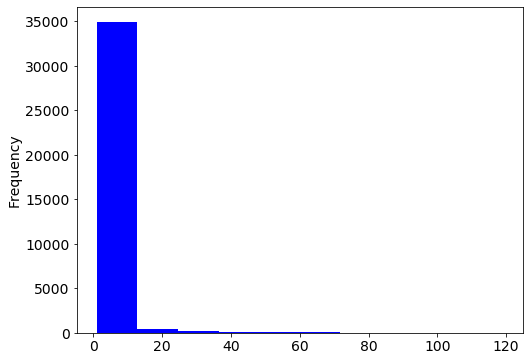

In [75]:
sipmdf['tot_charge'].plot(kind='hist', color='blue')

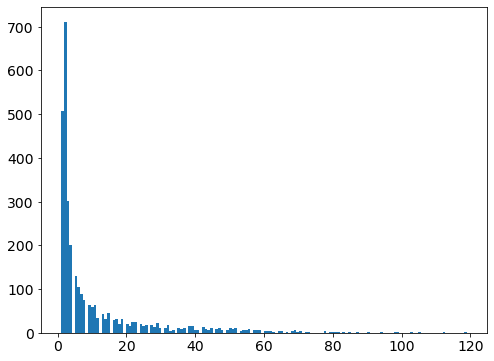

In [76]:
_, _, _ = plt.hist(sipmdf.groupby('sensor_id').tot_charge.max(), bins=150)

In [78]:
true_positions['S1e'] = pmt_response[pmt_response.time < s1_time].groupby('event_id').charge.sum()
true_positions['S2e'] = pmt_response[pmt_response.time > s1_time].groupby('event_id').charge.sum()

In [79]:
true_positions

,true_x,true_y,true_z,KE,S1e,S2e
event_id,,,,,,
102300,-62.492722,-368.931854,1170.443604,41.543297,31,8244
102301,-350.010284,-131.459610,1079.000977,41.543297,28,7992
102302,-5.467896,-10.789518,622.053040,41.543297,24,8910
102303,188.554916,98.998077,810.298279,41.543297,13,8854
102304,-86.077446,234.479935,1120.656860,53.747372,30,8567
...,...,...,...,...,...,...
102395,265.239990,112.474052,707.629028,41.543297,24,8783
102396,409.284576,33.916729,1009.684021,41.543297,19,7860
102397,360.786621,-186.341110,187.116257,41.543297,14,8064


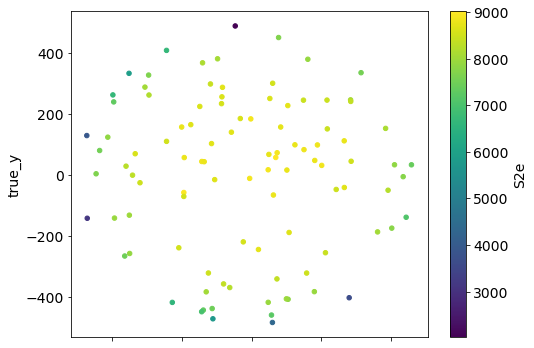

In [80]:
true_positions.plot(kind='scatter', x='true_x', y='true_y', c='S2e', cmap='viridis')

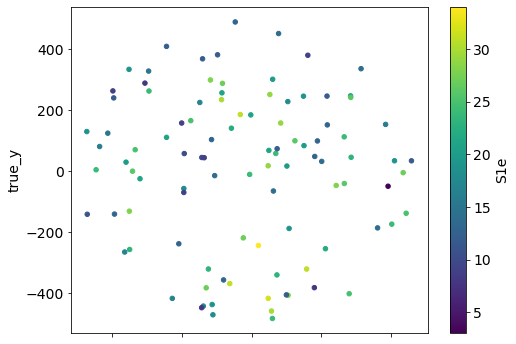

In [81]:
true_positions.plot(kind='scatter', x='true_x', y='true_y', c='S1e', cmap='viridis')